<a href="https://colab.research.google.com/github/sadikinisaac/general/blob/master/water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Beachwatch Logistic Regressions

In [4]:
!pip install metapack

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 112kB 13.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 19.6MB 50.3MB/s 
     |████████████████████████████████| 245kB 47.1MB/s 
     |████████████████████████████████| 286kB 54.8MB/s 
     |████████████████████████████████| 10.1MB 49.7MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 225kB 51.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 921kB 45.5MB/s 
     |████████████████████████████████| 11.8MB 41.9MB/s 
  Created wheel for petl: filename=petl-1.3.0-cp36-none-any.whl size=192852 sha256=22b7a985c65867f935f10ddc586a9574a1ab4058658854cdc419ec6afa48a6d3
  

In [0]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [6]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-beachwatch-4.zip')
beachwatch =    pkg.resource('beachwatch').read_csv(parse_dates=True)
measure_codes = pkg.resource('measure_codes').read_csv(parse_dates=True)
stations =      pkg.resource('stations').read_csv(parse_dates=True)

beachwatch.head()

,stationcode,stationgroup,sampledate,collectiontime,measure_code,analyte,methodname,unit,result,result_group_count,result_group_std,result_group_mean,result_group_25pctl,result_group_median,result_group_75pctl,result_gt_median,result_gt_mean,result_lte_25pctl,result_gte_75pctl,lresult,lresult_group_std,lresult_group_mean,lresult_group_25pctl,lresult_group_median,lresult_group_75pctl,lresult_gt_lmedian,lresult_gt_lmean,lresult_lte_25pctl,lresult_gte_75pctl,labbatch,resultqualcode,qacode,sampleagency,labagency,submittingagency
0,EH-010,EH,1999-05-26,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,1647.469843,376.478873,20.0,20.0,20.0,0.0,0.0,0.0,1.0,2.995732,1.439884,3.633361,2.995732,2.995732,2.995732,0.0,0.0,0.0,1.0,SH-5/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
1,EH-010,EH,1999-10-13,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,0.0,213,1647.469843,376.478873,20.0,20.0,20.0,0.0,0.0,1.0,0.0,NaN,1.439884,3.633361,2.995732,2.995732,2.995732,0.0,0.0,0.0,0.0,SH-10/13/1999,=,NR,SDCDEH,SDCDEH,SDCDEH
2,EH-010,EH,1999-10-26,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,1647.469843,376.478873,20.0,20.0,20.0,0.0,0.0,0.0,1.0,2.995732,1.439884,3.633361,2.995732,2.995732,2.995732,0.0,0.0,0.0,1.0,SH-10/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
3,EH-010,EH,2000-03-21,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,1647.469843,376.478873,20.0,20.0,20.0,0.0,0.0,0.0,1.0,2.995732,1.439884,3.633361,2.995732,2.995732,2.995732,0.0,0.0,0.0,1.0,SH-3/21/2000,<,NR,SDCDEH,SDCDEH,SDCDEH
4,EH-010,EH,2000-05-24,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,230.0,213,1647.469843,376.478873,20.0,20.0,20.0,1.0,0.0,0.0,1.0,5.438079,1.439884,3.633361,2.995732,2.995732,2.995732,1.0,1.0,0.0,1.0,SH-5/24/2000,=,NR,SDCDEH,SDCDEH,SDCDEH


In [7]:
beachwatch.lresult_gt_lmedian.value_counts(dropna=False)

0.0    136183
1.0     66074
Name: lresult_gt_lmedian, dtype: int64

In [8]:
# Proportion of gt_mean and mt_median that are different. 
len(beachwatch[ beachwatch.lresult_gt_lmedian.notnull() & beachwatch.lresult_gt_lmedian.notnull() &  
        (beachwatch.lresult_gt_lmedian != beachwatch.lresult_gt_lmean)])  / len(beachwatch)

0.043489224105964196

In [0]:
#Merge in environmental data

In [0]:
env_pkg =  mp.open_package('http://library.metatab.org/sandiegodata.org-water_quality-4.zip')

In [10]:
trr = env_pkg.resource('tides_river_rain').read_csv(parse_dates=True).set_index('date')
trr.head()

,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min
date,,,,,,,
1988-01-01,22.0,22.0,22.0,NaN,NaN,NaN,NaN
1988-01-02,20.0,42.0,42.0,NaN,NaN,NaN,NaN
1988-01-03,18.0,60.0,60.0,NaN,NaN,NaN,NaN
1988-01-04,18.0,56.0,60.0,NaN,NaN,NaN,NaN
1988-01-05,21.0,57.0,60.0,NaN,NaN,NaN,NaN


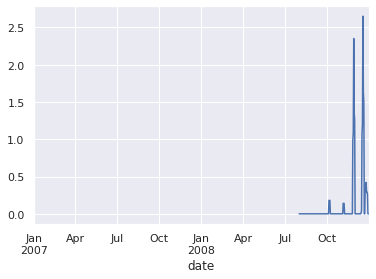

In [11]:
trr.loc['2007':'2008'].recent_precip.plot()

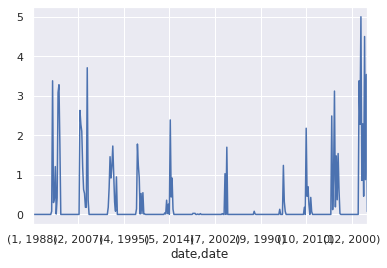

In [12]:
trr.groupby(by=[trr.index.month, trr.index.year]).sum().dailyprecip.plot()

In [13]:
bw_env = beachwatch.set_index('sampledate').join(trr)
bw_env['high_flow'] =  (bw_env.recent_total_discharge > bw_env.recent_total_discharge.median()).astype(int)
bw_env['ldischarge_rate'] = np.log(bw_env.discharge_rate)
bw_env.head()

,stationcode,stationgroup,collectiontime,measure_code,analyte,methodname,unit,result,result_group_count,result_group_std,result_group_mean,result_group_25pctl,result_group_median,result_group_75pctl,result_gt_median,result_gt_mean,result_lte_25pctl,result_gte_75pctl,lresult,lresult_group_std,lresult_group_mean,lresult_group_25pctl,lresult_group_median,lresult_group_75pctl,lresult_gt_lmedian,lresult_gt_lmean,lresult_lte_25pctl,lresult_gte_75pctl,labbatch,resultqualcode,qacode,sampleagency,labagency,submittingagency,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min,high_flow,ldischarge_rate
1998-07-21,SE-010,SE,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,4.0,527,225.561709,51.220114,2.0,4.0,20.0,0.0,0.0,0.0,0.0,1.386294,1.518733,1.973126,0.693147,1.386294,2.995732,0.0,0.0,0.0,0.0,SE-7/21/1998,=,NR,SEJPA,SEJPA,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-010,SE,2020-02-01,9,"Coliform, Total",MTF,MPN/100 mL,4.0,530,309.086717,84.126415,2.0,8.0,22.0,0.0,0.0,0.0,0.0,1.386294,1.720703,2.296871,0.693147,2.079442,3.091042,0.0,0.0,0.0,0.0,SE-7/21/1998,=,NR,SEJPA,SEJPA,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-010,SE,2020-02-01,26,Enterococcus,MTF,MPN/100 mL,2.0,488,148.631518,24.676230,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.693147,1.160104,1.216686,0.693147,0.693147,1.386294,0.0,0.0,0.0,0.0,SE-7/21/1998,<,NR,SEJPA,SEJPA,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-020,SE,2020-02-01,0,"Coliform, Fecal",MTF,MPN/100 mL,23.0,477,128.262880,20.035639,2.0,2.0,7.0,1.0,1.0,0.0,1.0,3.135494,1.184474,1.444595,0.693147,0.693147,1.945910,1.0,1.0,0.0,1.0,SE-7/21/1998,=,NR,SEJPA,SEJPA,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-020,SE,2020-02-01,9,"Coliform, Total",MTF,MPN/100 mL,23.0,477,263.711243,35.614256,2.0,4.0,11.0,1.0,0.0,0.0,1.0,3.135494,1.333927,1.685159,0.693147,1.386294,2.397895,1.0,1.0,0.0,1.0,SE-7/21/1998,=,NR,SEJPA,SEJPA,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752


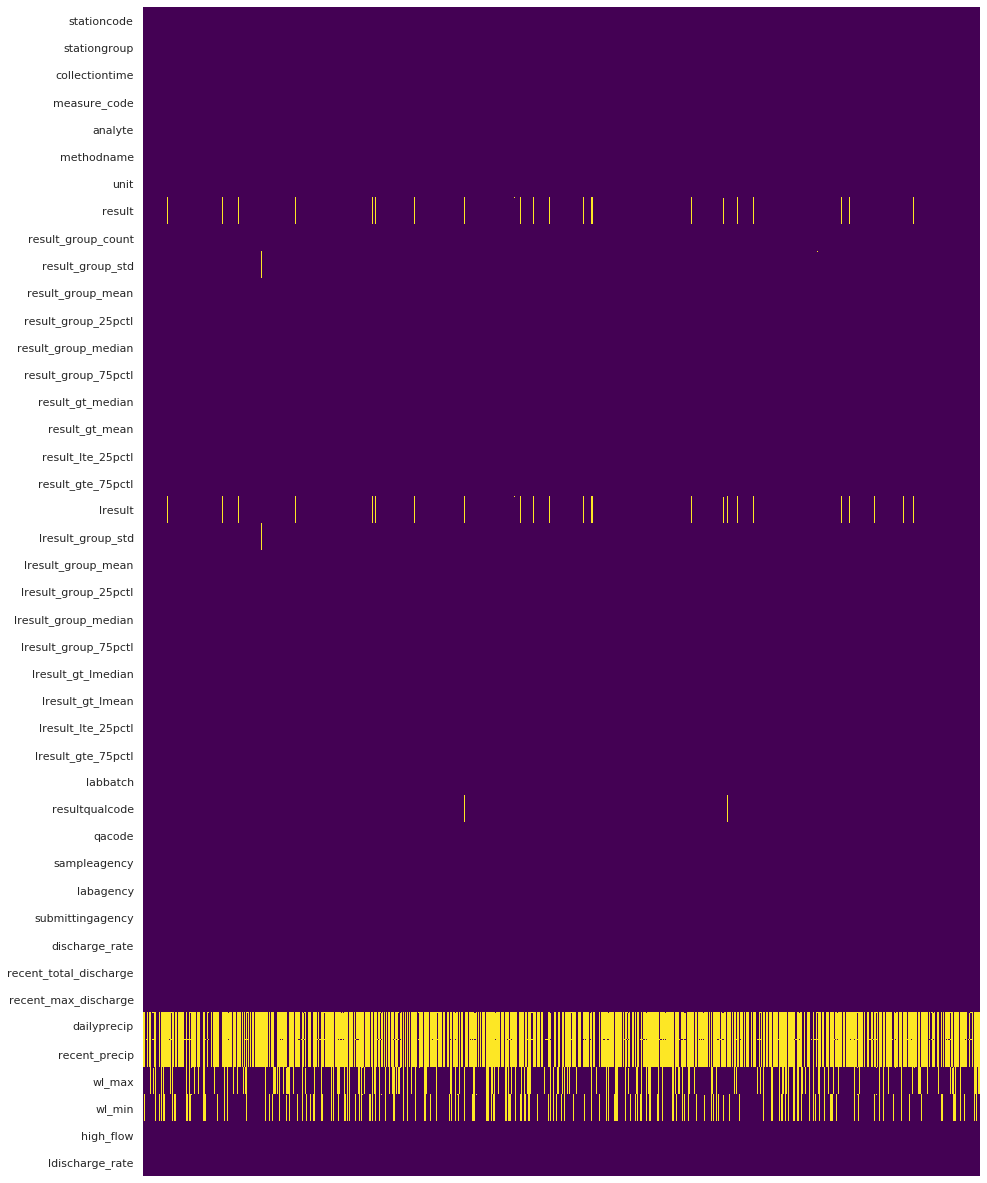

In [14]:
fig, ax = plt.subplots(figsize=(15,.5*len(bw_env.columns)))
sns.heatmap(bw_env.sample(10000).isnull().T,cbar=False,xticklabels=False,cmap = 'viridis', ax=ax );

In [15]:
sum(bw_env.recent_precip > 0.0)

8440

In [16]:
bw_env.groupby('lresult_gt_lmean').mean().discharge_rate.reset_index()

,lresult_gt_lmean,discharge_rate
0,0.0,10.482232
1,1.0,47.200024


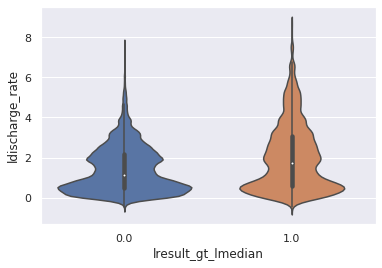

In [17]:
ax = sns.violinplot(x=bw_env.lresult_gt_lmedian, y=bw_env.ldischarge_rate)

In [18]:
bw_env.groupby('lresult_gt_lmean').discharge_rate.agg(['mean','std','median'])

,mean,std,median
lresult_gt_lmean,,,
0.0,10.482232,36.187658,3.15
1.0,47.200024,195.216645,5.70


In [19]:
bw_env.groupby('lresult_gt_lmean').mean().recent_precip

lresult_gt_lmean
0.0    0.024758
1.0    0.129421
Name: recent_precip, dtype: float64

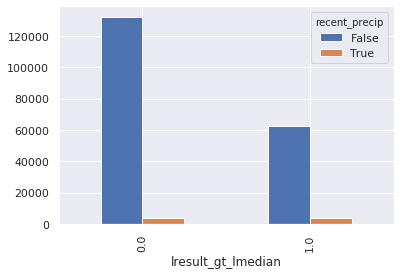

In [20]:
pd.crosstab(bw_env.lresult_gt_lmedian, bw_env.recent_precip > 0.01 ).plot(kind='bar')

In [21]:
def logit(y,X):
    import statsmodels.api as sm

    X_ = pd.DataFrame()
   
    X_['X'] = X
    X_['const'] = 1

    logit_model=sm.Logit(y,X_)
    result=logit_model.fit()
    print(result.summary())

    # Odds ratio and conf interval
    params = result.params
    conf = result.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print(np.exp(conf))
    
logit(
    y = bw_env.lresult_gt_lmedian.astype(int), 
    X = (bw_env.recent_precip.fillna(0) > 0).astype(int)
)

Optimization terminated successfully.
         Current function value: 0.629777
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     lresult_gt_lmedian   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Feb 2020   Pseudo R-squ.:                0.003209
Time:                        08:14:27   Log-Likelihood:            -1.2738e+05
converged:                       True   LL-Null:                   -1.2779e+05
Covariance Type:            nonrobust   LLR p-value:                2.207e-180
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.6477      0.022     28.995      0.000       0.604       0.691
const         -0.7525      0.

In [0]:
#That's an odds ratio of nearly 1:2, 
#so days with non-zero recent precipitation 
#are about twice as likely to have a bacteria county above the median

In [22]:
logit(
    y = bw_env.lresult_gt_lmedian.astype(int), 
    X = bw_env.recent_precip.fillna(0)
)

Optimization terminated successfully.
         Current function value: 0.628095
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     lresult_gt_lmedian   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Feb 2020   Pseudo R-squ.:                0.005872
Time:                        08:15:26   Log-Likelihood:            -1.2704e+05
converged:                       True   LL-Null:                   -1.2779e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.7654      0.054     32.978      0.000       1.660       1.870
const         -0.7477      0.

In [0]:
#this means that a 1 unit ( 1 inch ) increase 
#in the recent precipitation increases the odds of above 
#median bacteria counts by a factor of 6

In [23]:
logit(
    y = bw_env.lresult_gt_lmedian.astype(int), 
    X = bw_env.recent_precip.fillna(0)
)

Optimization terminated successfully.
         Current function value: 0.628095
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     lresult_gt_lmedian   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Feb 2020   Pseudo R-squ.:                0.005872
Time:                        08:15:53   Log-Likelihood:            -1.2704e+05
converged:                       True   LL-Null:                   -1.2779e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.7654      0.054     32.978      0.000       1.660       1.870
const         -0.7477      0.

In [24]:
_1 = pd.DataFrame()
_1['y'] = bw_env.lresult_gt_lmedian.astype(int)
_1['X'] = bw_env.recent_precip.apply(lambda x: 1 if x > 1.5 else 0 if x < .5 else np.nan)
_2 = _1.dropna()

logit(
    y = _2['y'],
    X = _2['X']
)

Optimization terminated successfully.
         Current function value: 0.578986
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                52202
Model:                          Logit   Df Residuals:                    52200
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Feb 2020   Pseudo R-squ.:                0.009148
Time:                        08:16:04   Log-Likelihood:                -30224.
converged:                       True   LL-Null:                       -30503.
Covariance Type:            nonrobust   LLR p-value:                2.171e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              3.5838      0.232     15.436      0.000       3.129       4.039
const         -1.0074      0.

In [0]:
#this means that a greater than median reading is 36 times 
#more likely with a recent rainfall of 1.5 inches or greater 
#than with .5 inch or less.

In [0]:
#Rain Seasonality

#Maybe there is a stonger correlation to precipitation 
#in the first rains of the season? The guess is that late in the season, 
#pollutants and nutrients have already been washed out by the early rains, 
#so there should be more pollution earlier in the season

In [0]:
# Compute the quartile of rainfall for each month

_1 = pd.qcut(trr.groupby(trr.index.month).sum().dailyprecip, 
             q=[0, .3, .5, .75, 1.], # .3 not .25 to smooth out summer
            labels=[1,2,3,4])

dmap = {e['date']:e['dailyprecip'] for _,e in _1.to_frame().reset_index().iterrows()}

#trr.apply( lambda row: dmap[row.index.month])
bw_env['month'] = bw_env.index.month
bw_env['precip_month_q'] = bw_env.month.apply(lambda v: dmap[v])

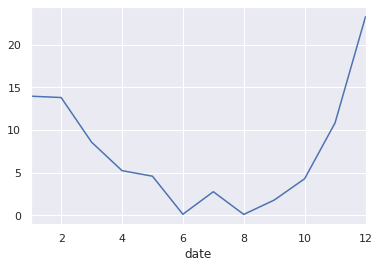

In [26]:
trr.groupby(trr.index.month).sum().dailyprecip.plot()

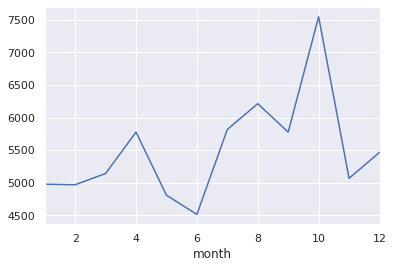

In [27]:
bw_env.groupby(bw_env.month).lresult_gt_lmedian.sum().plot()

In [28]:
bw_env.groupby(bw_env['precip_month_q']).lresult_gt_lmedian.sum()

precip_month_q
1    22320.0
2    12355.0
3    15986.0
4    15413.0
Name: lresult_gt_lmedian, dtype: float64

In [29]:
bw_env.index.month.all

<bound method Index._add_logical_methods.<locals>._make_logical_function.<locals>.logical_func of Int64Index([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=202257)>